# 1 - Création des fonctions NIPALS

In [48]:
import numpy as np
seed=0

In [49]:
def center_reduce(X:np.array):
    # On fait la moyenne et l'erreur standard sur les données non manquantes
    OVER_COLUMNS = 0
    OVER_ROWS = 1
    m = X.mean(axis=OVER_COLUMNS, where=np.isnan(X) == False)
    s = X.std(axis=OVER_COLUMNS, ddof=1, where=np.isnan(X) == False)
    return (X - m) / s, m, s

def center_reduce_inv(X, m, s):
    return X * s + m

In [50]:
def cp_fp(X, tol=10**-5, max_iter = 100):
    _, p = X.shape

    cp = X[:,0]
    fp = np.zeros(p)

    # On traite les valeurs manquantes comme des zéros.
    X[np.isnan(X)]   = 0
    cp[np.isnan(cp)] = 0

    for i in range(max_iter):
        fpm1 = fp
        # Itération de la méthode de la puissance
        # En effet à toute itération CP = X.dot(FP)
        # Donc on effectue l'opération FP = X.T.dot(X.dot(FP))
        fp = X.transpose().dot(cp)
        # on normalize FP:
        fp = fp / np.linalg.norm(fp, 2)
        cp = X.dot(fp)

        if np.linalg.norm(fp - fpm1, 2) < tol:
            break


    return cp, fp

def NIPALS(X, max_iter=200):
    """
    Effectue NIPALS sans traitements des données manquantes
    Données:
    X: Matrice des données
    max_iter: nombre d'itérations max de la méthode de la puissance
    Résultats:
    CP : Composantes principales
    FP : Facteurs principaux
    Xr : Reconstitution des données
    """
    n, p = X.shape
    X_cr, m, s = center_reduce(X)
    # On crée des matrices vides pour nos valeurs de retour
    CP = np.zeros((n, p))
    FP = np.zeros((p, p))
    Xr = np.zeros((n, p))
    for i in range(p):
        cp, fp = cp_fp(X_cr, max_iter)
        CP[:, i] = cp
        FP[:, i] = fp
        # Reconstitution partielle des données,
        # Partie des données non perdue par la projection sur FP_i
        reconstituted_from_CPi = np.outer(cp, fp)
        # On enlève toute la dimention de CPi de X.
        # On trouvera comme vec propre principal de ce nouveau Xt X
        # Un vec propre orthogonal au premier (le 2e vp de Xt X)
        X_cr = X_cr - reconstituted_from_CPi
    # Reconstitution complète de X
    Xr = CP.dot(FP.transpose())
    Xr = center_reduce_inv(Xr, m, s)
    return CP, FP, Xr


# 2 - TP Skulls

> Chargez le fichier des données : http://math.univ-lille1.fr/~preda/GIS4/tibetan_skull_missing.csv

> Il s’agit d’un jeu de données sur 32 cranes de deux types (A = mongolian et B = Indian) pour lesquels on
> connait 5 caractéristiques numériques. Le but est de construire un modèle prédictif du type de crane à partir
> des caractéristiques numériques (X1 - X5) à l’aide de la régression logistique binaire

Importons les donnéees avec Pandas

In [51]:
import pandas as pd

In [52]:
skulls_df = pd.read_csv("./tibetan_skull_missing.csv", sep=";")
skulls_df["type"] = skulls_df["type"].astype("category")
skulls_df.loc[:10]

length  breadth  height  face_height  face_breadth type
0    190.5    152.5   145.0         73.5         136.5    A
1    172.5    132.0   125.5         63.0         121.0    A
2    167.0    130.0   125.5         69.5         119.5    A
3    169.5    150.5   133.5         64.5         128.0    A
4      NaN    138.5   126.0         77.5         135.5    A
5    177.5    142.5   142.5          NaN         131.0    A
6    179.5    142.5   127.5         70.5         134.5    A
7    179.5    138.0   133.5         73.5         132.5    A
8    173.5    135.5   130.5         70.0         133.5    A
9    162.5    139.0   131.0         62.0         126.0    A
10   178.5      NaN   136.0         71.0           NaN    A

## 2.1 - Statistiques descriptives de nos données

In [53]:
skulls_df.describe()

length     breadth      height  face_height  face_breadth
count   29.000000   31.000000   31.000000    30.000000     30.000000
mean   180.637931  139.193548  133.322581    72.866667    133.750000
std      9.546780    6.913366    6.181354     5.527257      7.322321
min    162.500000  126.500000  121.500000    62.000000    118.500000
25%    173.500000  134.750000  129.250000    69.625000    131.625000
50%    179.500000  139.000000  133.500000    73.500000    134.500000
75%    185.000000  142.500000  137.250000    76.500000    136.500000
max    200.000000  153.000000  145.000000    82.500000    146.500000

Données manquantes par variable :

In [54]:
skulls_df.isna().sum()

length          3
breadth         1
height          1
face_height     2
face_breadth    2
type            1
dtype: int64

## 2.2 - Statistiques bivariées, unes par unes

J'utiliserai la librairie `scipy.stats`pour réaliser les tests statistiques, et `matplotlib.pyplot`/`seaborn` pour réaliser les visualisations.

### t-test

Effectuons des t_test de Welch (variances différentes) pour chaque couple ($X_i$ | type=A, $X_i$ | type=B) et choisisons un risque de $5\%$

In [55]:
from scipy.stats import ttest_ind

for feature in skulls_df.columns[:-1]:
    print(f"t-test {feature} ~ type :")
    df = skulls_df[skulls_df["type"].notna()]
    df = df[df[feature].notna()]
    group_A = df[df["type"] == 'A'][feature]
    group_B = df[df["type"] == 'B'][feature]

    t_test_results = ttest_ind(group_A, group_B, alternative="two-sided", equal_var=False)

    print(f"\t t-stat = {t_test_results.statistic}\n\t pvalue = {t_test_results.pvalue}")

t-test length ~ type :
	 t-stat = -4.000525638663838
	 pvalue = 0.00048202795414029775
t-test breadth ~ type :
	 t-stat = 0.35800893232991826
	 pvalue = 0.7232121568963974
t-test height ~ type :
	 t-stat = -1.2880348423058905
	 pvalue = 0.20848435126782933
t-test face_height ~ type :
	 t-stat = -4.346235206829219
	 pvalue = 0.0001777857561594652
t-test face_breadth ~ type :
	 t-stat = -2.7193402006523195
	 pvalue = 0.012907414052497807


On rejette donc $H_0$ pour `length`, `face_height` et `face_breadth`.

On en conclus donc qu'il y a des différences significatives entre les cranes mongoles et indiens sur ces attributs.

### Visualisations

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

#### Distributions

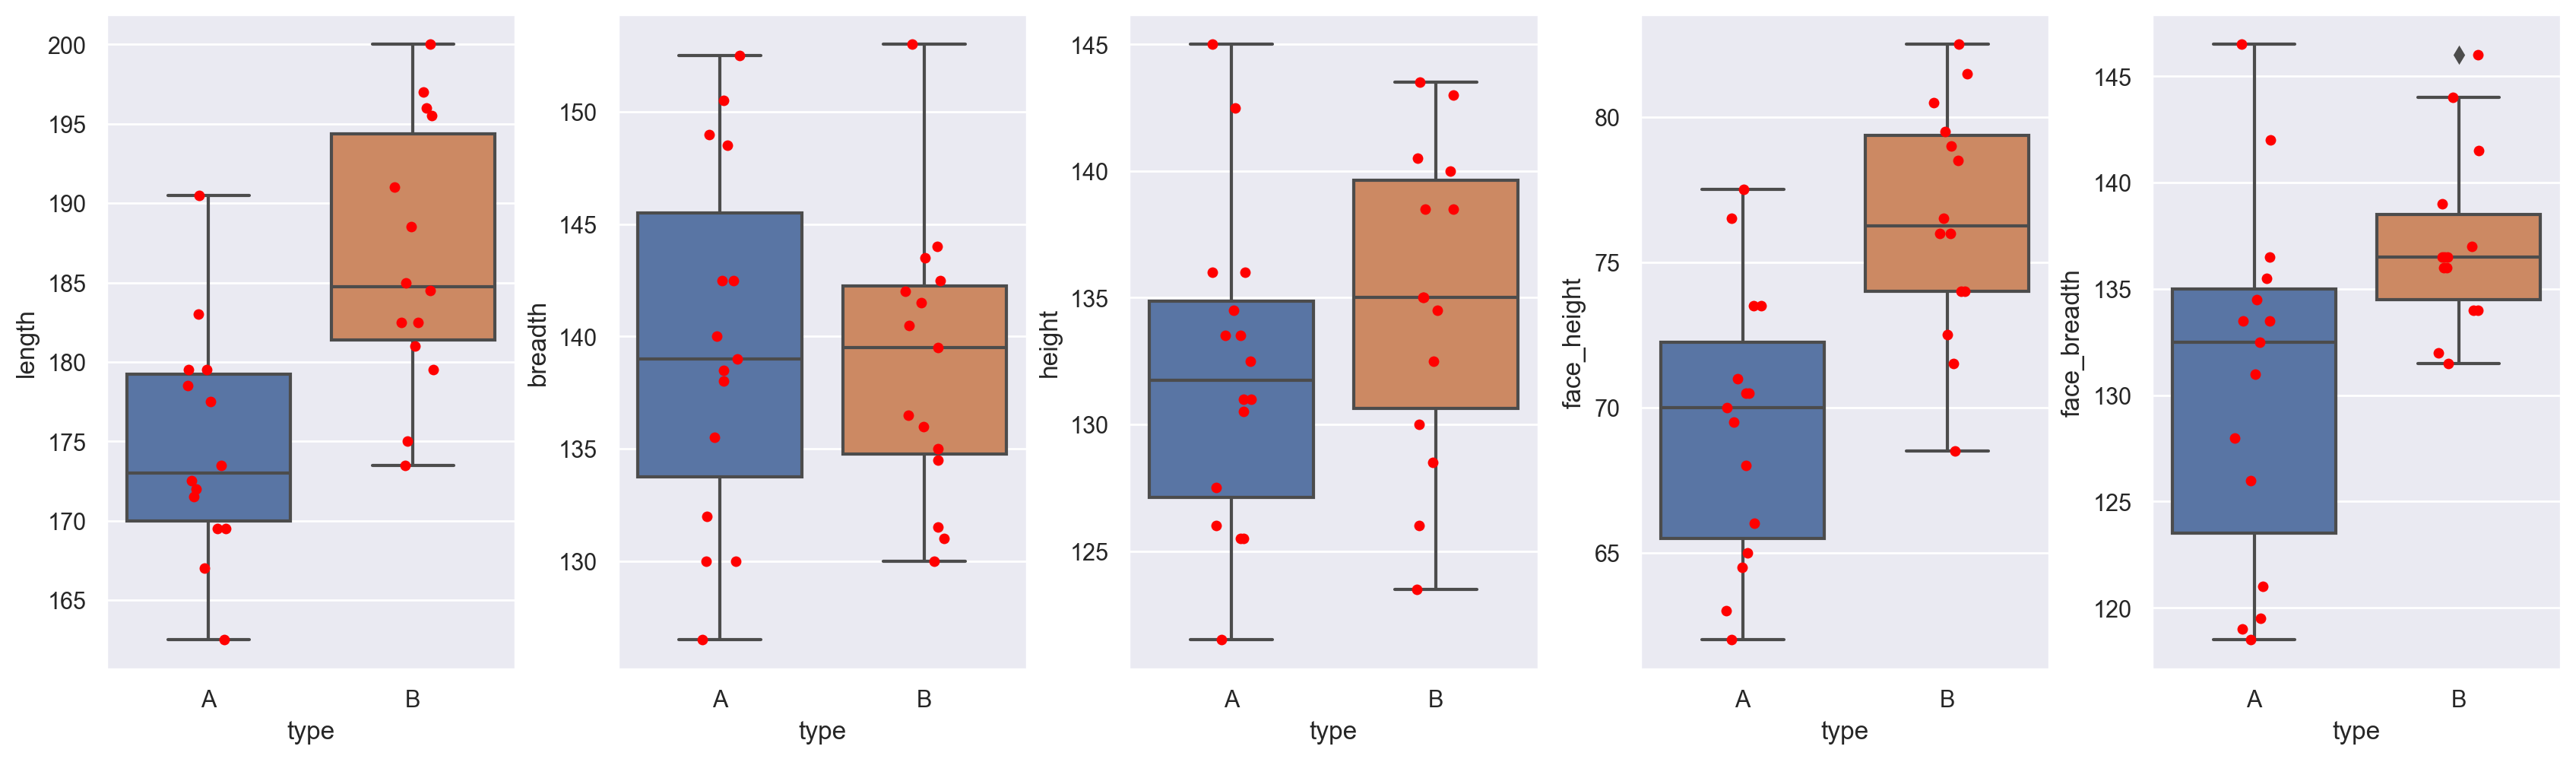

In [57]:
fig, ax = plt.subplots(ncols=5)
fig.dpi = 200
fig.set_size_inches(17, 5) # Largeur/Longeur
fig.tight_layout() # Garantir un espacement lisible


for i, col in enumerate(skulls_df.columns[:-1]):
    sns.boxplot(data=skulls_df, x="type", y=col, ax=ax[i]);
    sns.stripplot(data=skulls_df, x="type", y=col, ax=ax[i], color="red");

On voit bien sur les boxplots que les variables breadth et height sont moins différentes par rapport à leur groupe.

En revanche les variables length, face_height et face_breadth ont des distributions clairement différentes par rapport au groupe.

#### Valeurs manquantes

On peut aussi utiliser la librairie `missingno` qui a de nombreux outils pour visualiser les valeurs manquantes.

In [58]:
import missingno as msno

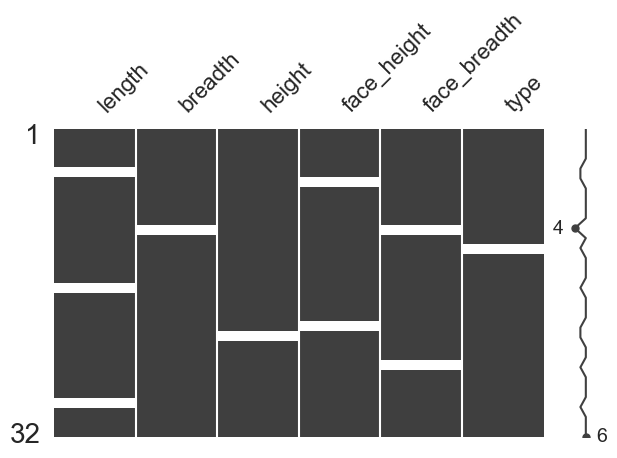

In [59]:
msno.matrix(skulls_df, figsize=(7, 4));

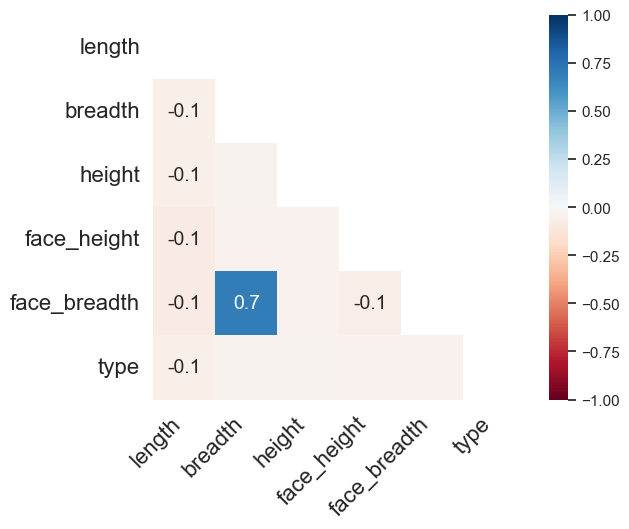

In [60]:
msno.heatmap(skulls_df, figsize=(6, 5));

On a ici les correlations des valeurs manquantes.

On peut voir que les valeurs manquantes sur `type` ne sont pas fortement corrélées avec des manquantes sur d'autres.

Il faut faire attention: `face_breadth` et `breadth`  ont une plus haute correlation, mais cela est clairement du à un manque de données.

Je vais essayer de créer une fonction identique à `marginplot` du package `VIM` pour `R`

In [61]:
# Attention, convertir les variables catégoriques en numériques avant utilisation.

def R_VIM_marginplot_layout(data, x_name, y_name, margin_percent=.05):

    # Data Min and Max
    xlim = (data[x_name].min(), data[x_name].max())
    ylim = (data[y_name].min(), data[y_name].max())
    # Absolute Margin
    x_margin = (xlim[1] - xlim[0]) * margin_percent
    y_margin = (ylim[1] - ylim[0]) * margin_percent
    # Graph Limits
    xlim = (xlim[0] - x_margin, xlim[1] + x_margin)
    ylim = (ylim[0] - y_margin, ylim[1] + y_margin)

    # Subplots and layout
    fig, ax = plt.subplots(3, 3, figsize=(8, 8),
                           gridspec_kw={
        "width_ratios": [2, 1, 8],
        "height_ratios": [8, 1, 2]
    })

    # Naming for readability
    ((y_bplot,              y_splot_x_missing,      xy_splot),
     (number_y_missing,     xy_splot_xy_missing,    x_splot_y_missing),
     (number_xy_missing,    number_x_missing,       x_bplot)) = ax

    # Setting graph limits
    #   Scatter Plot of non missing values
    xy_splot.set_xlim(xlim)
    xy_splot.set_ylim(ylim)
    #   Boxplots
    y_bplot.set_ylim(ylim)
    x_bplot.set_xlim(xlim)
    #   Missing value scatter plots
    y_splot_x_missing.set_ylim(ylim)
    x_splot_y_missing.set_xlim(xlim)

    def remove_axes(ax):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

    # Removing unwanted labels
    remove_axes(number_xy_missing)
    remove_axes(number_x_missing)
    remove_axes(number_y_missing)
    remove_axes(xy_splot_xy_missing)
    remove_axes(xy_splot)
    remove_axes(y_splot_x_missing)
    remove_axes(x_splot_y_missing)
    y_bplot.axes.xaxis.set_visible(False)
    x_bplot.axes.yaxis.set_visible(False)

    # Automatic Spacing
    fig.tight_layout()

    return fig, ax


def R_VIM_marginplot(data: pd.DataFrame, x_name: str, y_name: str) -> None:
    # We don't copy the values
    data["x_is_missing"] = data[x_name].isna()
    data["y_is_missing"] = data[y_name].isna()
    data["xy_is_missing"] = data["x_is_missing"] & data["y_is_missing"]
    x_missing_count = np.sum(data["x_is_missing"])
    y_missing_count = np.sum(data["y_is_missing"])
    xy_missing_count = np.sum(data["xy_is_missing"])

    # Get figure and axes with the proper layout
    fig, ax = R_VIM_marginplot_layout(data, x_name, y_name)

    # Naming for readability
    ((y_bplot,              y_splot_x_missing,      xy_splot),
     (number_y_missing,     xy_splot_xy_missing,    x_splot_y_missing),
     (number_xy_missing,    number_x_missing,       x_bplot)) = ax

    # Pick a color palette that is close to that of R's VIM marginplot
    VIM_colors = sns.color_palette(palette=["#4c97d4", "#cb5e84"], n_colors=2)

    # Scatterplot of the non missing values
    sns.scatterplot(data=data, x=x_name, y=y_name,
                    ax=xy_splot, color=VIM_colors[0])

    # Scatterplot of the value when the other is missing
    sns.scatterplot(data=data[data["x_is_missing"]],
                    x=0, y=y_name, ax=y_splot_x_missing, color=VIM_colors[1])  # Y
    sns.scatterplot(data=data[data["y_is_missing"]],
                    x=x_name, y=0, ax=x_splot_y_missing, color=VIM_colors[1])  # X

    # Boxplots of the values, by other missing and other non missing
    sns.boxplot(data=data, x="x_is_missing", y=y_name,
                ax=y_bplot, palette=VIM_colors)                # Y
    sns.boxplot(data=data, x=x_name, y="y_is_missing",
                ax=x_bplot, palette=VIM_colors, orient="h")    # X

    # ""Scatterplot"" of missing values
    if xy_missing_count > 0:
        sns.scatterplot(data=pd.DataFrame(
            {'x': [0 for _ in range(xy_missing_count)], 'y': [0 for _ in range(xy_missing_count)]}), # In case I ever add alpha values
            x='x', y='y', color=VIM_colors[1], ax=xy_splot_xy_missing)

    # Numbers of missing values
    text_parameters = {"x": .5, "y": .5,
                       "horizontalalignment": "center", "verticalalignment": "center",
                       "fontdict": {"size": 16, "color": VIM_colors[1]}}
    #   Missing x
    number_x_missing.text(s=str(x_missing_count),   **text_parameters)
    #   Missing y
    number_y_missing.text(s=str(y_missing_count),   **text_parameters)
    #   Missing xy
    number_xy_missing.text(s=str(xy_missing_count), **text_parameters)

    # On supprime les colonnes ajoutées (car on a évité la copie)
    data.drop(["x_is_missing", "y_is_missing",
              "xy_is_missing"], axis=1, inplace=True)

Utilisons marginplot sur quelques couples de variables. Je testerai sur (`length`, `height`) (corr -0.1) et sur (`breadth`, `face_breadth`) (corr 0.7)

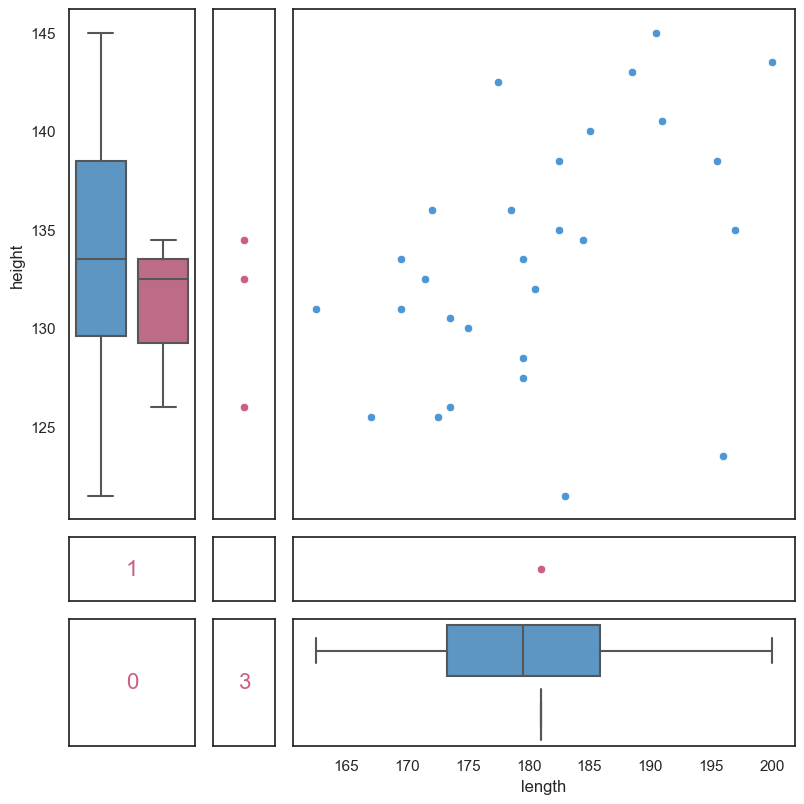

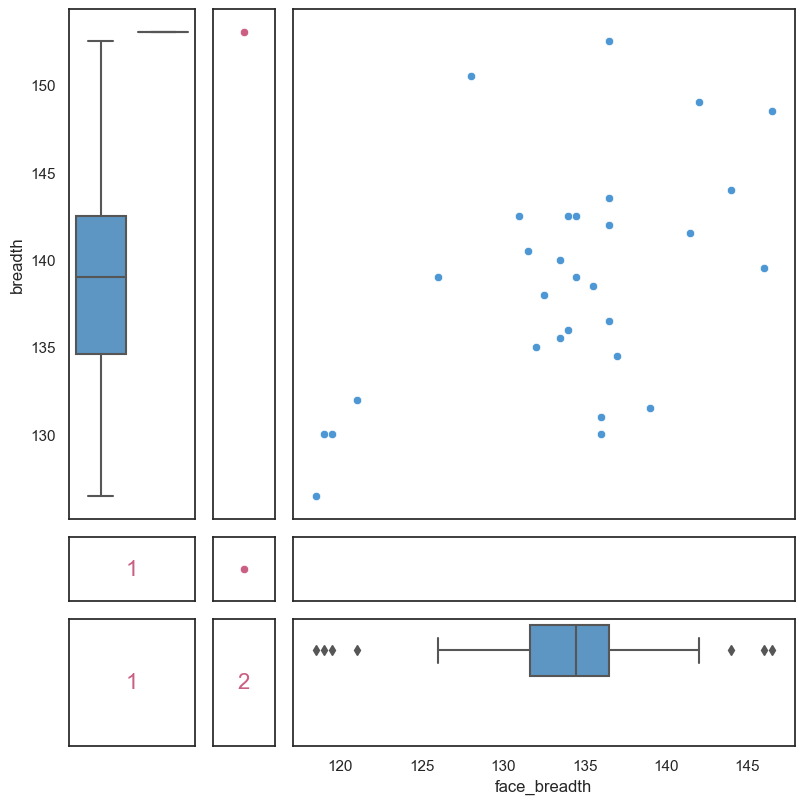

In [62]:
sns.set_style("white")
R_VIM_marginplot(skulls_df, "length", "height")
R_VIM_marginplot(skulls_df, "face_breadth", "breadth")
sns.set_style("darkgrid")

On voit qu'il y a trop peu de valeurs manquantes pour réfuter MCAR, on pourra utiliser MICE.

## 2.3 - Régression logistique en présence des données manquantes

### 2.3.1 - Première classification sans imputation des données manquantes.

Nous utiliserons la librairie `statsmodels` pour les modèles linéaires et l'imputation.

In [63]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

Il est possible de faire un modèle de plutot bonne qualité et simplicité en incluant uniquement `length`, `face_height` et `face_breadth` (pour qui les t-test étaient significatifs), ou en incluant `length` en `height` (trouvés par selection d'attribut par régularisation L1).

Cependant, je prendrai l'exemple d'un cas où nous voudrions un modèle "plus complexe", sans selection de variables.

D'abord, nous allons séparer les données avec valeurs manquantes retirées en une partie entrainement et une partie test en s'aidant d'un utilitaire de scikit-learn.

In [64]:
# Préparation du dataset pour utilisation avec statsmodels
skulls_df_dummy = pd.get_dummies(skulls_df, drop_first=True, dummy_na=True)
skulls_df_dummy["type_B"].mask(skulls_df_dummy["type_nan"] == 1, np.nan, inplace=True)
skulls_df_dummy.drop(["type_nan"], axis=1, inplace=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(skulls_df_dummy.drop(["type_B"], axis=1),
                                                    skulls_df_dummy["type_B"], 
                                                    test_size=0.3, random_state=seed)

train_dropna = pd.concat([X_train, y_train], axis=1).dropna()


Ensuite, nous entrainerons un premier modèle sur des données avec les lignes à valeurs manquantes retirées. Puis nous comparerons avec un modèle entrainé sur données imputées.

On comparera ensuite leur performance sur le dataset de test.

In [65]:
# Si on utilise la syntaxe type R :
#logr = smf.logit("type_B ~ length + breadth + height + face_height + face_breadth", data=train_dropna)
logr = sm.Logit(train_dropna["type_B"], train_dropna.drop(["type_B"], axis=1))
logr_res = logr.fit_regularized(alpha=.005)
print(logr_res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0023301655293157097
            Iterations: 89
            Function evaluations: 94
            Gradient evaluations: 89
                           Logit Regression Results                           
Dep. Variable:                 type_B   No. Observations:                   17
Model:                          Logit   Df Residuals:                       13
Method:                           MLE   Df Model:                            3
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.9995
Time:                        12:23:29   Log-Likelihood:             -0.0054126
converged:                       True   LL-Null:                       -11.754
Covariance Type:            nonrobust   LLR p-value:                 3.181e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

c:\Users\lcubeddu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\lcubeddu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Il se trouve qu'il y a séparation parfaite dans les données pour ces prédicteurs. Cela a pour effet de créer un modèle avec coefficients infinis (le sigmoide devient discontinu et saute de 0 à 1).

Pour calculer des coeffs, nous sommes donc forcés d'ajouter un coefficient de régularisation.

On peut être certains que le modèle est overfit, à cause d'une quantité de données trop basse (et aussi d'un choix de variables peu judicieux, d'où les pvalue horribles)

### Imputation des valeurs manquantes avec MICE

In [66]:
# On ajoute les données
imp = sm.MICEData(skulls_df_dummy, k_pmm=5)
# On choisit d'imputer type_dummy avec la régression logistique
imp.set_imputer("type_B", model_class=sm.Logit)

In [67]:
%%capture
# On fait 10 itérations de mice sur notre dataset
imp.update_all(10);

#### Résultat sans imputation:

In [77]:
skulls_df_dummy[[any(row) for row in skulls_df.isna().to_numpy()]]

length  breadth  height  face_height  face_breadth  type_B
4      NaN    138.5   126.0         77.5         135.5     0.0
5    177.5    142.5   142.5          NaN         131.0     0.0
10   178.5      NaN   136.0         71.0           NaN     0.0
12   180.5    139.0   132.0         74.5         134.5     NaN
16     NaN    126.5   134.5         66.0         118.5     0.0
20   184.5    141.5   134.5          NaN         141.5     1.0
21   181.0    142.0     NaN         79.0         136.5     1.0
24   175.0    153.0   130.0         76.5           NaN     1.0
28     NaN    143.5   132.5         74.0         136.5     1.0

#### Résultat avec imputation:

In [69]:
skulls_df_dummy_imp = imp.data
skulls_df_dummy_imp[[any(row) for row in skulls_df.isna().to_numpy()]]

length  breadth  height  face_height  face_breadth  type_B
4    177.5    138.5   126.0         77.5         135.5     0.0
5    177.5    142.5   142.5         71.0         131.0     0.0
10   178.5    143.5   136.0         71.0         146.5     0.0
12   180.5    139.0   132.0         74.5         134.5     0.0
16   179.5    126.5   134.5         66.0         118.5     0.0
20   184.5    141.5   134.5         65.0         141.5     1.0
21   181.0    142.0   140.0         79.0         136.5     1.0
24   175.0    153.0   130.0         76.5         128.0     1.0
28   175.0    143.5   132.5         74.0         136.5     1.0

### 2.3.2 - Classification avec imputation des données manquantes.

On va refaire une régression logistique avec toutes les colonnes, cette fois avec les données manquantes imputées par MICE.

In [70]:
# On recrée LA MÊME séparation du dataset, mais avec les données imputées
X_train, X_test, y_train, y_test = train_test_split(skulls_df_dummy_imp.drop(["type_B"], axis=1),
                                                    skulls_df_dummy_imp["type_B"], 
                                                    test_size=0.3, random_state=seed)

logr_imp = sm.Logit(y_train, X_train)
logr_res_imp = logr_imp.fit()
print(logr_res_imp.summary())

Optimization terminated successfully.
         Current function value: 0.318028
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 type_B   No. Observations:                   22
Model:                          Logit   Df Residuals:                       17
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.5412
Time:                        12:23:31   Log-Likelihood:                -6.9966
converged:                       True   LL-Null:                       -15.249
Covariance Type:            nonrobust   LLR p-value:                  0.002411
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
length           0.3110      0.221      1.409      0.159      -0.121       0.743
breadth         -0.2604

On se retrouve cette fois sans séparation parfaite. Cela nous permet d'effectuer la régression logistique sans régularisation, et d'obtenir un modèle moins biaisé, avec cette fois un $R^2$ raisonnable de $0.4405$. (mais toujours biaisé à cause de la mauvaise sélection de variables)

### 2.3.3 - Comparaisons des accuracy sur le dataset de test.

On va utiliser les utilitaires de test d'accuracy de scikit-learn.

In [71]:
from sklearn.metrics import accuracy_score

#### Accuracy du modèle sans imputation

In [72]:
y_pred = logr_res.predict(X_test).map(lambda p_B: 1 if p_B >= 0.5 else 0)
print(f"Accuracy : {accuracy_score(y_pred, y_test):%}")

Accuracy : 60.000000%


#### Accuracy du modèle avec imputation

In [73]:
y_pred = logr_res_imp.predict(X_test).map(lambda p_B: 1 if p_B >= 0.5 else 0)
print(f"Accuracy : {accuracy_score(y_pred, y_test):%}")

Accuracy : 40.000000%


J'ai essayé de nombreuses répartitions aléatoires pour la découpe du dataset, et de nombreux paramètres, cependant mon hypothèse de départ selon laquelle le modèle serait meilleur avec imputation n'est tout simplement pas vérifiée.

Le modèle avec les valeurs manquantes retirées est meilleur que celui sans. Je ne peux pas expliquer pourquoi.

Je suspecte que le dataset est bien trop petit, ou bien que les lignes où il y a des données manquantes sont moins réprésentatives du dataset général.

Je ne pense pas que la régularisation l1 (qui serait une bonne idée vu qu'aucun choix de variable n'a été effectué) soit le coupable de ce résultat, car le coefficient est très petit.

## 2.4 - ROC Curve

Je vais utiliser les utilitaires de scikit learn pour créer la courbe ROC.

Imputé:

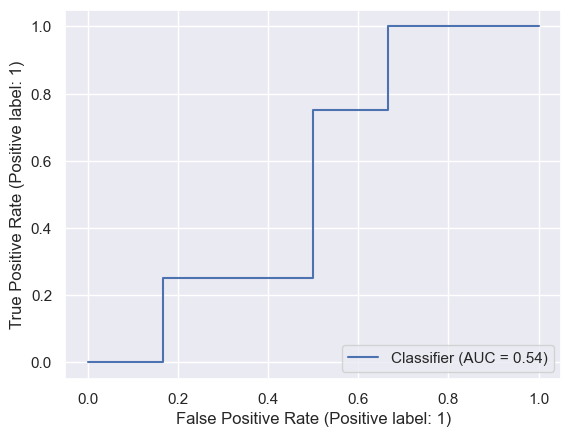

In [74]:
from sklearn.metrics import RocCurveDisplay

y_pred = logr_res_imp.predict(X_test)

RocCurveDisplay.from_predictions(y_test, y_pred);

Valeurs manquantes retirées:

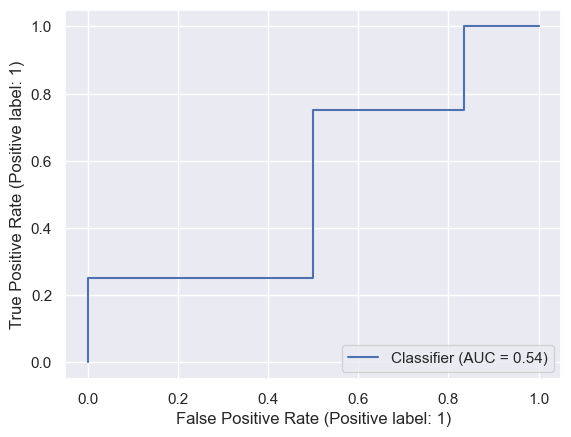

In [75]:
y_pred = logr_res.predict(X_test)

RocCurveDisplay.from_predictions(y_test, y_pred);

Encore une fois le modèle avec les données manquantes retirées est meilleur que le modèle avec données manquantes imputées.